# Fast L-BFGS and VL-BFGS on GPU

Ce projet comporte de nombreux codes séparés du notebook:

- **VL_BFGS.py** contient l'implémentation de l'algorithme principal. Il ne repose que sur le framework pytorch, les fonctions "two-loops" ainsi que le line search ont aussi été personnellement implémentés. Les explications concernant les différentes fonctions ainsi que les frontières entre GPU et CPU sont aussi présentes dans ce script.


- **common.py** contient la fonction permettant de simuler des données pour une regression linéaire ou logistique ainsi que les fonctions de perte et de gradient implémentées en pytorch et en numpy. Ces fonctions sont nécessaires pour résourdre le problème d'optimisation en utilisant L-BFGS.


- **simulation.py** est un code autonome permettant de comparer précisement les perfomances des 3 algorithmes suivant la taille des données (cf partie 1.4)


- **feature_engineering.py** est le code utilisé pour créer un grand nombre de variables à partir du dataset utilisé pour montrer un cas d'utilisation de nos algorithmes sur des données réelles.

(Toutes les performances présentées dans ce notebook sont mesurées sur un GPU Nvidia GTX 1060 et un CPU intel i7 4 coeurs + 4 threads)

## 0. MODULE

In [1]:
# Computation
import numpy as np
import torch

from scipy.optimize import fmin_l_bfgs_b

# Random
from torch.distributions.normal import Normal

# Perso
from common import *
from VL_BFGS import *
from feature_engineering import *

# Plot
import matplotlib.pyplot as plt

## 1. DONNÉES SIMULÉES

### 1.1 Vérification de la convergence

Nous allons commencer par vérifier la convergence de nos deux algorithmes en les comparant à l'implémentation Scipy. 

Pour cela nous simulons un petit jeu de données pour une régression linéaire.

In [2]:
n_features = 1000
n = Normal(0, 1)
coefs = n.sample(torch.Size([n_features]))

lbda = .1
w0 = torch.zeros(n_features)

f = linear_loss
f_grad = linear_grad

X, y = simulate_data(coefs, n_samples=50000, for_logreg=False)

Scipy n'accepte que des array numpy en input, pour cela nous transformons nos torch tensor. Nous utilisons aussi des fonctions (fonction de perte et gradient) codées en numpy.

In [3]:
w0_numpy = w0.numpy()

f_numpy = linear_loss_numpy
f_grad_numpy = linear_grad_numpy

X_numpy, y_numpy = X.numpy(), y.numpy()

In [4]:
# Scipy
_, f_min_scipy, _ = fmin_l_bfgs_b(f_numpy, w0_numpy, f_grad_numpy, args=(X_numpy, y_numpy, lbda))

# Notre implémentation de L-BFGS
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cpu')
_, f_min, _, _ = optimizer.fit(X, y, w0, lbda)

# Notre implémentation de VL-BFGS
optimizer_VL = lbfgs(f, f_grad, m=10, vector_free=True, device='cpu')
_, f_min_VL, _, _ = optimizer.fit(X, y, w0, lbda)

Nous comparons enfin les loss obtenues par les 3 algorithmes.

In [5]:
print('Scipy: %.4f' % (f_min_scipy))
print('L-BFGS: %.4f' % (f_min[-1]))
print('VL-BFGS: %.4f' % (f_min_VL[-1]))

Scipy: 46.8647
L-BFGS: 46.8647
VL-BFGS: 46.8647


Nos deux implémentations convergent donc bien, nous allons donc maintenant pouvoir nous intéresser à leur vitesse de convergence afin d'assurer la pertinence de développer une version GPU de cet algorithme.

In [6]:
del X_numpy, y_numpy
torch.cuda.empty_cache()

### 1.2 Convergence et temps de calcul

In [7]:
n_samples = 200000
n_features = 3000

n = Normal(0, 1)
coefs = n.sample(torch.Size([n_features]))

lbda = .1

#### 1.2.1 Regression linéaire

In [8]:
X, y = simulate_data(coefs, n_samples, for_logreg=False)

In [9]:
w0 = torch.zeros(n_features)
f = linear_loss
f_grad = linear_grad

In [10]:
# CPU
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cpu')
_, objectives_cpu, computing_time_cpu, _ = optimizer.fit(X, y, w0, lbda)

# GPU
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cuda:0')
_, objectives_gpu, computing_time_gpu, _ = optimizer.fit(X, y, w0, lbda)

# GPU VL
optimizer = lbfgs(f, f_grad, m=10, vector_free=True, device='cuda:0')
_, objectives_gpu_vl, computing_time_gpu_vl, _ = optimizer.fit(X, y, w0, lbda)

In [11]:
f_min = min(objectives_gpu[-1], objectives_cpu[-1], objectives_gpu_vl[-1])

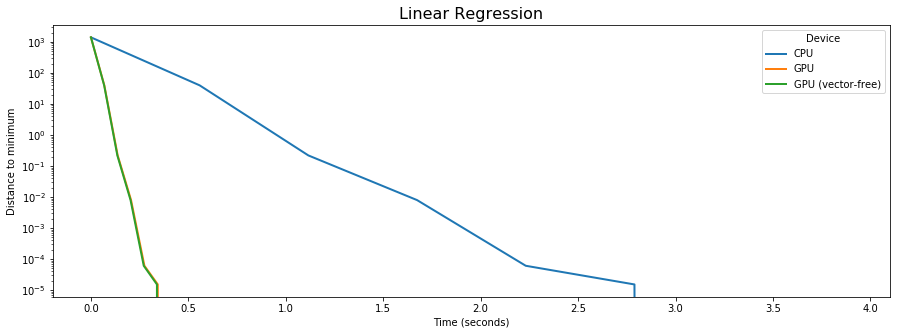

In [12]:
plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, computing_time_cpu, len(objectives_cpu)), objectives_cpu - f_min, lw=2, label='CPU')
plt.semilogy(np.linspace(0, computing_time_gpu, len(objectives_gpu)), objectives_gpu - f_min, lw=2, label='GPU')
plt.semilogy(np.linspace(0, computing_time_gpu_vl, len(objectives_gpu_vl)), 
             objectives_gpu_vl - f_min, lw=2, label='GPU (vector-free)')
plt.yscale('log')
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Device', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()

#### 1.2.2 Régression logistique

In [13]:
y = torch.sign(y)

In [14]:
w0 = torch.zeros(n_features)
f = logistic_loss
f_grad = logistic_grad

In [15]:
# CPU
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cpu')
_, objectives_cpu, computing_time_cpu, _ = optimizer.fit(X, y, w0, lbda)

# GPU
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cuda:0')
_, objectives_gpu, computing_time_gpu, _ = optimizer.fit(X, y, w0, lbda)

# GPU VL
optimizer = lbfgs(f, f_grad, m=10, vector_free=True, device='cuda:0')
_, objectives_gpu_vl, computing_time_gpu_vl, _ = optimizer.fit(X, y, w0, lbda)

In [16]:
f_min = min(objectives_gpu[-1], objectives_cpu[-1], objectives_gpu_vl[-1])

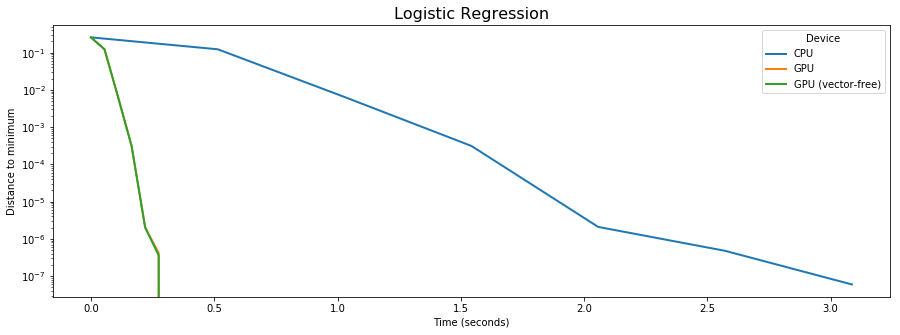

In [17]:
plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, computing_time_cpu, len(objectives_cpu)), objectives_cpu - f_min, lw=2, label='CPU')
plt.semilogy(np.linspace(0, computing_time_gpu, len(objectives_gpu)), objectives_gpu - f_min, lw=2, label='GPU')
plt.semilogy(np.linspace(0, computing_time_gpu_vl, len(objectives_gpu_vl)), 
             objectives_gpu_vl - f_min, lw=2, label='GPU (vector-free)')
plt.yscale('log')
plt.title("Logistic Regression", fontsize=16)
plt.legend(title='Device', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()

Le temps de calcul est beaucoup moins important sur GPU que sur CPU dans le cas des deux problèmes d'optimisation considérés.

Néanmoins VL-BFGS ne semble pas plus rapide que L-BFGS. Cela est normal puisque le premier a d'abord été pensé pour être distribué et scalable du point de vue des features. Il serait donc plus rapide que le second sur un plus grand nombre de GPUs et pour un plus grand nombre de variables (que nous n'avons pas pu atteindre dû à une mémoire RAM insuffisante).

Dans cette première comparaison nous n'avons pas pris en compte le temps de communication entre le CPU et le GPU (le temps nécessaire pour que les données soient envoyées au GPU), ce qui nuit à la performance globale des algorithmes lorsqu'ils tournent sur ce dernier.

### 1.3 Temps d'exécution en fonction de la dimension

Dans cette partie nous allons regarder l'impact de la dimension sur la vitesse de convergence des algorithmes. Ici le temps de communication n'est toujours pas considéré.

In [18]:
f = logistic_loss
f_grad = logistic_grad

n_features = np.arange(200, 10000, 200)
n_samples = 50000

cpu_time, gpu_time, gpu_vl_time = [], [], []

for n_feature in n_features:
    
    n = Normal(0, 1)
    coefs = n.sample(torch.Size([n_feature]))
    w0 = torch.zeros(n_feature)
    X, y = simulate_data(coefs, n_samples=50000, for_logreg=True)
    
    # CPU
    optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cpu')
    _, _, computing_time_cpu, com_time_cpu = optimizer.fit(X, y, w0, lbda)
    
    # GPU
    optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cuda:0')
    _, _, computing_time_gpu, com_time_gpu = optimizer.fit(X, y, w0, lbda)
    
    # GPU VL
    optimizer = lbfgs(f, f_grad, m=10, vector_free=True, device='cuda:0')
    _, _, computing_time_gpu_vl, com_time_gpu_vl = optimizer.fit(X, y, w0, lbda)
    
    cpu_time.append(computing_time_cpu + com_time_cpu)
    gpu_time.append(computing_time_gpu + com_time_gpu)
    gpu_vl_time.append(computing_time_gpu_vl + com_time_gpu_vl)

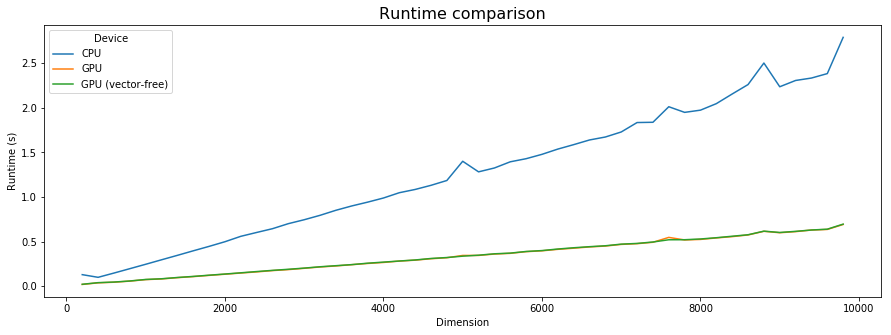

In [19]:
plt.figure(figsize=(15, 5))
plt.title('Runtime comparison', fontsize=16)
plt.plot(n_features, cpu_time, label='CPU')
plt.plot(n_features, gpu_time, label='GPU')
plt.plot(n_features, gpu_vl_time, label='GPU (vector-free)')
plt.legend(title='Device', loc='best')
plt.ylabel('Runtime (s)')
plt.xlabel('Dimension')
plt.show()

### 1.4 Comparaison détaillée

Dans cette partie nous allons regarder précisément le temps de communication entre le CPU et le GPU et le temps de calcul. Nous allons exécuter chaque algorithme 10x, et ce pour plusieurs datasets (toujours simulés) afin d'obtenir des statistiques plus représentatives.

Ici nous utilisons un fichier python séparé pour conserver un notebook relativement clair.

In [20]:
!python simulation.py

>> Training on 100000 samples and 1000 features

   CPU computing time: 0.50s +-0.00s
   CPU communication time: 0.00s +-0.00s

   GPU computing time: 0.07s +-0.00s
   GPU communication time: 0.08s +-0.00s

   GPU (vector free) computing time: 0.07s +-0.00s
   GPU (vector free) communicating time: 0.08s +-0.00s

-------------------------------------------------

>> Training on 100000 samples and 2000 features

   CPU computing time: 1.03s +-0.04s
   CPU communication time: 0.00s +-0.00s

   GPU computing time: 0.12s +-0.02s
   GPU communication time: 0.17s +-0.02s

   GPU (vector free) computing time: 0.11s +-0.01s
   GPU (vector free) communicating time: 0.16s +-0.00s

-------------------------------------------------

>> Training on 100000 samples and 4000 features

   CPU computing time: 2.01s +-0.01s
   CPU communication time: 0.00s +-0.00s

   GPU computing time: 0.22s +-0.01s
   GPU communication time: 0.32s +-0.02s

   GPU (vector free) computing time: 0.22s +-0.00s
   GPU (vect

Ces résultats nous permettent de faire plusieurs remarques:

- Le temps de transfert des données du CPU au GPU est toujours supérieur au temps de calcul sur ce dernier.

- Les calculs sur GPU sont 10x plus rapide que sur CPU.

## 2. DONNÉES RÉELLES 

In [21]:
del X, y
torch.cuda.empty_cache()

Dans cette partie nous allons appliquer nos deux algorithmes à un jeu de données réelles.

### 2.1 Données

Le dataset comporte 33 variables, lesquelles sont différentes mesures physiques concernant l'activité solaire. Il y a environ 500000 observations, chacune représentant un instant t. Il s'agit de prédire, pour chaque instant t, la présence d'une tempête solaire.

Il s'agit d'une tache de classification pour laquelle nous pouvons utiliser une regression logistique. Cependant ce modèle ne permet pas naturellement d'assimiler la relation temporelle entre les différentes observations. Afin de palier ce défaut nous allons faire un important feature engineering afin de créer de nombreuses variables "temporelles". Nous allons par exemple créer une variable valant, pour l'observation t et le variable v, la moyenne de la variable v sur l'intervalle [t-1h, t]. 

En faisant ça pour toutes les variables, en utilisant différentes mesures (moyenne, médiane, variance, minimum, maximum) et sur plusieurs intervalles temporels (1h, 3h, 5h, 10h, 20h) nous obtenons un total de 1749.

In [22]:
print('>> Loading data')
X = np.load('data/data_train.npy')
y = pd.read_csv('data/labels_train.csv')

print('>> To tensor')
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y.values, dtype=torch.float).squeeze()

print('>> Training on %2d samples and %2d features' % X.size())

>> Loading data
>> To tensor
>> Training on 509834 samples and 1749 features


### 2.2 Comparaison

In [23]:
# Parameters
lbda = .1

# Initialization
w0 = torch.rand(X.size(1))
f = logistic_loss
f_grad = logistic_grad

In [24]:
# CPU
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cpu')
_, objectives_cpu, computing_time_cpu, com_time_cpu = optimizer.fit(X, y, w0, lbda)

# GPU
optimizer = lbfgs(f, f_grad, m=10, vector_free=False, device='cuda:0')
_, objectives_gpu, computing_time_gpu, com_time_gpu = optimizer.fit(X, y, w0, lbda)

# GPU VL
optimizer = lbfgs(f, f_grad, m=10, vector_free=True, device='cuda:0')
_, objectives_gpu_vl, computing_time_gpu_vl, com_time_gpu_vl = optimizer.fit(X, y, w0, lbda)

In [25]:
f_min = min(objectives_gpu[-1], objectives_cpu[-1], objectives_gpu_vl[-1])

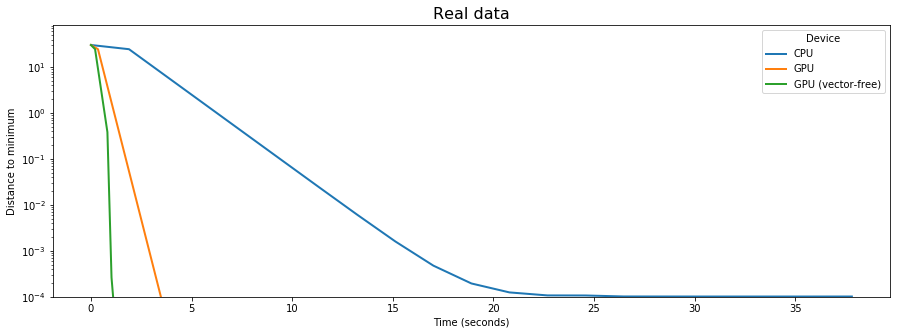

In [30]:
plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, computing_time_cpu + com_time_cpu, len(objectives_cpu)), 
             objectives_cpu - f_min, lw=2, label='CPU')
plt.semilogy(np.linspace(0, computing_time_gpu + com_time_gpu, len(objectives_gpu)), 
             objectives_gpu - f_min, lw=2, label='GPU')
plt.semilogy(np.linspace(0, computing_time_gpu_vl + com_time_gpu_vl, len(objectives_gpu_vl)), 
             objectives_gpu_vl - f_min, lw=2, label='GPU (vector-free)')
plt.yscale('log')
plt.ylim(10e-5)
plt.title("Real data", fontsize=16)
plt.legend(title='Device', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()

## 3. CONCLUSION 

L-BFGS est un algorithme dont le speed-up sur GPU est important. L'alternative VL-BFGS n'est pas plus rapide quand on ne dispose que d'un seul GPU. Néanmoins celui-ci permet de mieux distribuer les calculs et les données. En effet, il divise l'étape **two-loop**, qui comporte de nombreuses multiplications de vecteurs, par une double étape:

- Une unique multiplication de matrice.

- Reformulation de l'étape **two-loop** de façon à ce qu'elle ne comporte que des calculs impliquant des scalaires.

En conséquence, VL-BFGS présente l'avantage d'être indépendant de la dimension du problème et d'être facilement distribuée (autant d'un point de vue de la vitesse de calcul et de la mémoire)